This notebook takes the features classified as targets from the notebook "classify all features extracted from all the runs", finds experiment-wide means and standard deviations, 

In [12]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt
import sqlite3

In [13]:
EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'

In [14]:
# produced by the notebook "classify all features extracted from all the runs"
TEMP_DIR = '/home/ubuntu'
SEQUENCES_WITH_SPECIES_FILE_NAME = '{}/sequences-with-species-df.pkl'.format(TEMP_DIR)


In [15]:
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

In [16]:
EXTRACTED_FEATURES_DIR = "{}/extracted-features".format(EXPERIMENT_DIR)
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)


In [25]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select sequence,charge,file_idx,peak_idx,number_of_runs_identified,human,run_name,batch,intensity,isotope_idx_not_in_saturation from features where human is false order by intensity desc', db_conn)
db_conn.close()


In [26]:
sequences_df['log_intensity'] = np.log2(sequences_df.intensity)

#### use this sample of e.coli sequences that occur in a majority of the runs to analyse the intensity consistency

In [27]:
sequences_df[(sequences_df.number_of_runs_identified > 15) & (sequences_df.human == False)][['sequence','charge','intensity','file_idx']].sample(10).sort_values(by=['intensity','sequence','charge'], ascending=False, inplace=False)


,sequence,charge,intensity,file_idx
9197,ATVILAHTIK,2,3119,3
16801,ISELSEGQIDTLR,2,1923,5
37780,YAGLSEQALYYIGGVIK,2,821,4
40929,Q[-17.0265]PDAM[15.9949]THPDGMQIK,2,745,15
43465,MDQTYSLESFLNHVQK,3,692,7
62742,YYLATGGGDISQAEVLLK,2,429,11
83672,KWDLGDILGAK,2,270,0
98001,TALITGALQGIGEGIAR,2,182,12
100491,FPEHCGIGIKPCSEEGTKR,2,162,10
103419,ITSFSHPEIGTVVVSES,2,132,3


#### analyse a selected sequence across the experiment for runs in which it was classified as a target

In [28]:
selected_sequence = 'DAMVPMGGLLCMK'
selected_sequence_charge = 2

In [29]:
selected_sequence_df = sequences_df[(sequences_df.sequence == selected_sequence) & (sequences_df.charge == selected_sequence_charge)].copy()
selected_sequence_df.sort_values(by=['batch','run_name'], inplace=True)

#### compare the intensities across the experiment for the selected sequence

In [30]:
selected_sequence_1to1_df = selected_sequence_df[selected_sequence_df.batch == '1to1']
selected_sequence_1to3_df = selected_sequence_df[selected_sequence_df.batch == '1to3']

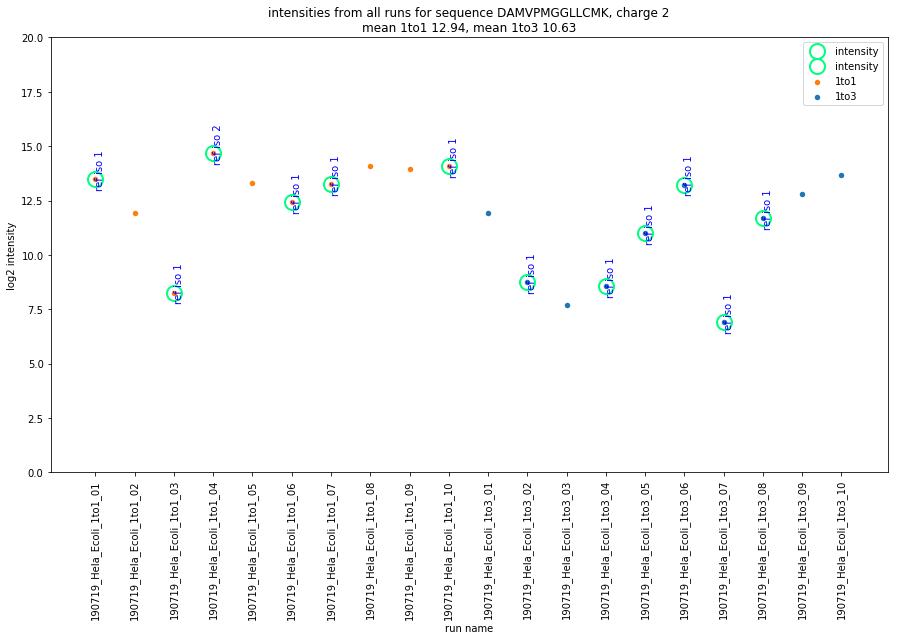

In [31]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

mean_1to1 = round(np.mean(np.log2(selected_sequence_1to1_df.intensity)), 2)
mean_1to3 = round(np.mean(np.log2(selected_sequence_1to3_df.intensity)), 2)

plt.title('intensities from all runs for sequence {}, charge {}\nmean 1to1 {}, mean 1to3 {}'.format(selected_sequence, selected_sequence_charge, mean_1to1, mean_1to3))

ax1.scatter(selected_sequence_1to1_df.run_name, np.log2(selected_sequence_1to1_df.intensity), marker='o', color='tab:orange', lw=0, s=30, alpha=1.0, label='1to1')
ax1.scatter(selected_sequence_1to3_df.run_name, np.log2(selected_sequence_1to3_df.intensity), marker='o', color='tab:blue', lw=0, s=30, alpha=1.0, label='1to3')

# highlight whether a point was adjusted for saturation
adj_sat_1to1 = selected_sequence_1to1_df[(selected_sequence_1to1_df.isotope_idx_not_in_saturation > 0)]
if len(adj_sat_1to1) > 0:
    ax1.plot(adj_sat_1to1.run_name, np.log2(adj_sat_1to1.intensity), marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15)

adj_sat_1to3 = selected_sequence_1to3_df[(selected_sequence_1to3_df.isotope_idx_not_in_saturation > 0)]
if len(adj_sat_1to3) > 0:
    ax1.plot(adj_sat_1to3.run_name, np.log2(adj_sat_1to3.intensity), marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15)

# show which isotope was used as a reference
text_style = dict(size=10, color='blue')
for idx,row in adj_sat_1to1.iterrows():
    ax1.text(row.run_name, np.log2(row.intensity)+1, "ref iso {}".format(int(row.isotope_idx_not_in_saturation)), **text_style, rotation=90)
for idx,row in adj_sat_1to3.iterrows():
    ax1.text(row.run_name, np.log2(row.intensity)+1, "ref iso {}".format(int(row.isotope_idx_not_in_saturation)), **text_style, rotation=90)

plt.xlabel('run name')
plt.ylabel('log2 intensity')
plt.legend(loc='best')

# plt.xlim((0,50))
plt.ylim((0,20))
plt.xticks(rotation=90)

plt.show()

#### look at the distribution of intensity deltas for sequences in 1to1 runs 01 and 02

In [32]:
run_A = '190719_Hela_Ecoli_1to1_01'
run_B = '190719_Hela_Ecoli_1to1_02'
sequences_in_run_01_df = sequences_df[(sequences_df.file_idx == file_idx_for_run(run_A))]
sequences_in_run_02_df = sequences_df[(sequences_df.file_idx == file_idx_for_run(run_B))]

In [33]:
sequences_in_both_runs_df = pd.merge(sequences_in_run_01_df, sequences_in_run_02_df, how='inner', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [34]:
sequences_in_both_runs_df['delta_log_intensity'] = sequences_in_both_runs_df.log_intensity_x - sequences_in_both_runs_df.log_intensity_y

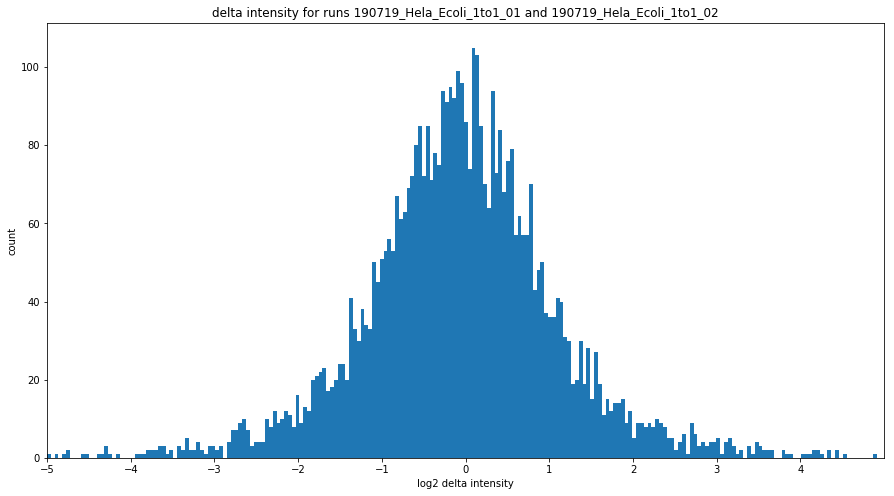

In [35]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 250
hist, bins, _ = plt.hist(sequences_in_both_runs_df.delta_log_intensity, bins=bins)
plt.xlabel('log2 delta intensity')
plt.ylabel('count')
plt.title('delta intensity for runs {} and {}'.format(run_A, run_B))
ax1.set(xticks=range(-5,5), xlim=[-5, 5])

plt.show()

In [36]:
ecoli_sequences_df = sequences_df[(sequences_df.human == False) & (sequences_df.number_of_runs_identified >= 15)]
# find the median intensity of each sequence in each 1to1 and 1to3 batch
batch_medians_l = []
for group_name,group_df in ecoli_sequences_df.groupby(['sequence','charge'], as_index=False):
    batch_1to1_median = group_df[group_df.batch == '1to1'].intensity.median()
    batch_1to3_median = group_df[group_df.batch == '1to3'].intensity.median()
    batch_medians_l.append((group_name[0], group_name[1], batch_1to1_median, batch_1to3_median))
batch_medians_df = pd.DataFrame(batch_medians_l, columns=['sequence','charge','batch_1to1_median','batch_1to3_median'])
batch_medians_df['log_batch_1to1_median'] = np.log2(batch_medians_df.batch_1to1_median)
batch_medians_df['log_batch_1to3_median'] = np.log2(batch_medians_df.batch_1to3_median)
batch_medians_df['delta_log_median'] = batch_medians_df.log_batch_1to3_median - batch_medians_df.log_batch_1to1_median

In [37]:
batch_medians_df.sample(n=5)

,sequence,charge,batch_1to1_median,batch_1to3_median,log_batch_1to1_median,log_batch_1to3_median,delta_log_median
3301,NDAAVLLVDHQAGLLSLVR,3,474.0,1521.0,8.888743,10.570804,1.682061
2414,ILASDVVSPLDVPGFDNSAMDGYAVR,3,649.0,204.5,9.342075,7.675957,-1.666118
1733,GGEM[15.9949]IAQGTPAEIMR,2,921.0,1515.0,9.847057,10.565102,0.718045
782,DLEHPIEVPVGK,2,2545.5,4052.5,11.313733,11.984596,0.670863
3997,SNPNRPATEIYR,2,1083.5,3134.0,10.081483,11.613789,1.532306


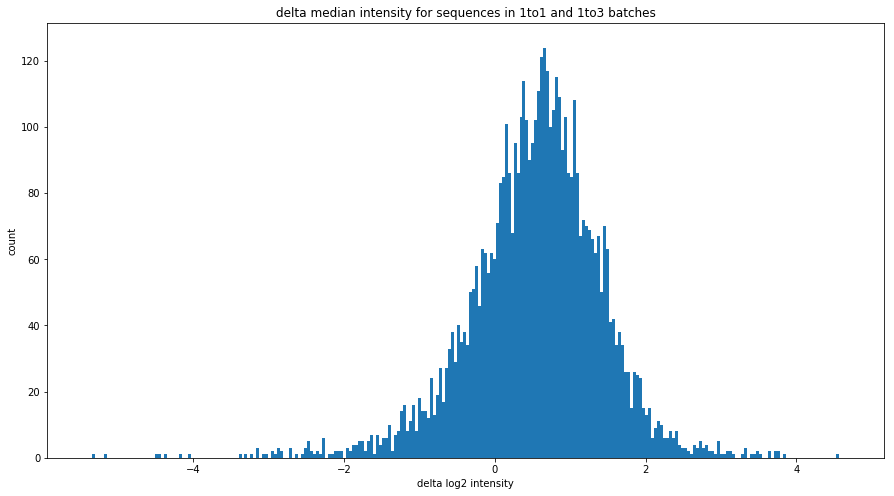

In [38]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 250
hist, bins, _ = plt.hist(batch_medians_df.delta_log_median, bins=bins)
plt.xlabel('delta log2 intensity')
plt.ylabel('count')
plt.title('delta median intensity for sequences in 1to1 and 1to3 batches')
# ax1.set(xticks=range(-5,5), xlim=[-5, 5])

plt.show()

In [39]:
ecoli_sequences_df = sequences_df[(sequences_df.human == False) & (sequences_df.number_of_runs_identified >= 15)]
# find the median intensity of each sequence in each 1to1 and 1to3 batch
batch_means_l = []
for group_name,group_df in ecoli_sequences_df.groupby(['sequence','charge'], as_index=False):
    batch_1to1_mean = group_df[group_df.batch == '1to1'].intensity.mean()
    batch_1to3_mean = group_df[group_df.batch == '1to3'].intensity.mean()
    batch_means_l.append((group_name[0], group_name[1], batch_1to1_mean, batch_1to3_mean))
batch_means_df = pd.DataFrame(batch_means_l, columns=['sequence','charge','batch_1to1_mean','batch_1to3_mean'])
batch_means_df['log_batch_1to1_mean'] = np.log2(batch_means_df.batch_1to1_mean)
batch_means_df['log_batch_1to3_mean'] = np.log2(batch_means_df.batch_1to3_mean)
batch_means_df['delta_log_mean'] = batch_means_df.log_batch_1to3_mean - batch_means_df.log_batch_1to1_mean

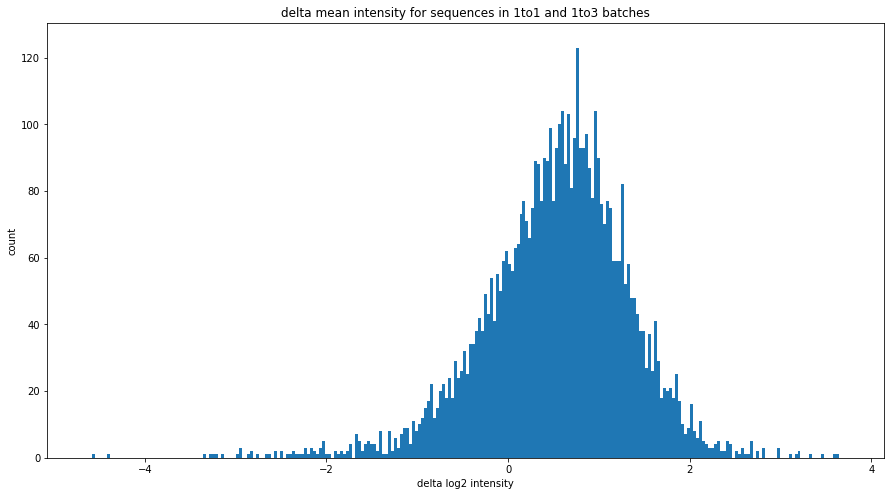

In [40]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 250
hist, bins, _ = plt.hist(batch_means_df.delta_log_mean, bins=bins)
plt.xlabel('delta log2 intensity')
plt.ylabel('count')
plt.title('delta mean intensity for sequences in 1to1 and 1to3 batches')
# ax1.set(xticks=range(-5,5), xlim=[-5, 5])

plt.show()